# How to better understand incorrect predictions from a Random Forest Classifier

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.preprocessing import MinMaxScaler
from graphviz import Digraph
import copy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import shap

%matplotlib inline

#### As a test case we'll use the breast cancer dataset from scikit learn

In [2]:
data = load_breast_cancer()

#### The data come with a bunch of metadata that we need to unpack into a dataframe

In [3]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [4]:
data['target_names']

array(['malignant', 'benign'], dtype='<U9')

In [5]:
data_df = pd.DataFrame(data['data'])

In [6]:
# clean up the columns
data_df.columns = [i.replace(' ', '_') for i in data['feature_names']]

In [7]:
# add the target column to the dataset
data_df['target']=data['target']

#### The description attribute contains some useful information about the data

In [8]:
data['DESCR'].split('\n')

['.. _breast_cancer_dataset:',
 '',
 'Breast cancer wisconsin (diagnostic) dataset',
 '--------------------------------------------',
 '',
 '**Data Set Characteristics:**',
 '',
 '    :Number of Instances: 569',
 '',
 '    :Number of Attributes: 30 numeric, predictive attributes and the class',
 '',
 '    :Attribute Information:',
 '        - radius (mean of distances from center to points on the perimeter)',
 '        - texture (standard deviation of gray-scale values)',
 '        - perimeter',
 '        - area',
 '        - smoothness (local variation in radius lengths)',
 '        - compactness (perimeter^2 / area - 1.0)',
 '        - concavity (severity of concave portions of the contour)',
 '        - concave points (number of concave portions of the contour)',
 '        - symmetry',
 '        - fractal dimension ("coastline approximation" - 1)',
 '',
 '        The mean, standard error, and "worst" or largest (mean of the three',
 '        worst/largest values) of these features w

#### Check what the data actually look like

In [9]:
data_df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [10]:
data_df['target'].value_counts()

1    357
0    212
Name: target, dtype: int64

### Prepare the data and fit model
- Split into train and test sets
- Instantiate the RF classifier
- Fit the training data
- Predict the test set

_Using `random_state` for reproducibility_

In [11]:
#scale all features to between 0 and 1

scaler = MinMaxScaler()
data_scale = scaler.fit_transform(data_df)

In [12]:
data_df = pd.DataFrame(data_scale, columns = data_df.columns)

In [13]:
data_df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864,0.0
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878,0.0
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433,0.0
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711,0.0
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595,0.0


In [14]:
test = data_df.sample(frac = 0.3, random_state=181)
data_df_sub = data_df.drop(test.index)
hold_out = data_df_sub.sample(frac = 0.2, random_state = 216)
train = data_df_sub.drop(hold_out.index)

In [15]:
rf_class = RandomForestClassifier(random_state=132)

In [16]:
model = rf_class.fit(train.drop('target', axis = 1), train['target'])

#### Check to see the values of each hyperparameter

In [17]:
model

RandomForestClassifier(random_state=132)

In [18]:
test['pred'] = model.predict(test.drop('target', axis = 1))

In [19]:
test.drop(['target', 'pred'], axis = 1)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
310,0.223342,0.317890,0.211043,0.116734,0.320574,0.101681,0.037090,0.057058,0.442424,0.238416,...,0.166489,0.387260,0.151950,0.073216,0.337648,0.078984,0.063219,0.197285,0.378869,0.095369
407,0.277770,0.394319,0.268399,0.157370,0.206554,0.195632,0.143533,0.092793,0.262626,0.235468,...,0.230167,0.399520,0.205289,0.113203,0.150895,0.161355,0.146805,0.192474,0.181944,0.173619
506,0.247953,0.349341,0.246562,0.131326,0.514309,0.293908,0.191542,0.107654,0.537374,0.399747,...,0.186055,0.323827,0.172917,0.081130,0.455854,0.198126,0.282348,0.277938,0.225508,0.218746
185,0.146670,0.182618,0.138000,0.073807,0.361470,0.084565,0.003742,0.011948,0.324747,0.221567,...,0.140164,0.244136,0.124409,0.061886,0.534438,0.072387,0.005527,0.035808,0.269663,0.143841
505,0.127550,0.115996,0.140488,0.054719,0.657850,0.616588,0.278351,0.349801,0.503535,0.964406,...,0.094984,0.160448,0.094925,0.035121,0.854718,0.328909,0.232668,0.369416,0.252908,0.533648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,0.259785,0.300643,0.257757,0.143542,0.424483,0.265076,0.187559,0.189911,0.436869,0.290017,...,0.250445,0.336354,0.227302,0.121092,0.471703,0.204238,0.213339,0.348797,0.285630,0.212908
476,0.341663,0.365911,0.335982,0.201442,0.331137,0.280412,0.118627,0.151988,0.225253,0.213353,...,0.303095,0.406183,0.307236,0.158106,0.291422,0.306206,0.200639,0.460137,0.191011,0.154401
518,0.279190,0.287792,0.280976,0.148293,0.624447,0.450034,0.113051,0.263569,0.327778,0.475358,...,0.253291,0.329158,0.243538,0.120306,0.491514,0.260801,0.099521,0.376632,0.200473,0.222288
252,0.603389,0.341901,0.600580,0.450689,0.483615,0.507699,0.566307,0.484095,0.339899,0.358256,...,0.617218,0.361674,0.544798,0.429562,0.659248,0.551280,0.678035,0.861512,0.233392,0.489702


FileNotFoundError: [Errno 2] No such file or directory: '/visualizations/confusion_matrix.jpg'

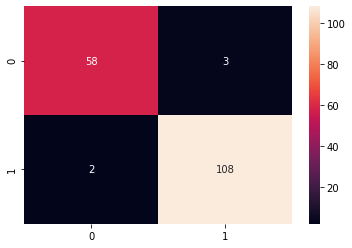

In [128]:
sns.heatmap(confusion_matrix(test['target'], test['pred']), annot=True, fmt='.3g')
plt.savefig('/visualizations/confusion_matrix.jpg', bbox_inches = 'tight')

In [21]:
fpr, tpr, thresholds = roc_curve(test['target'], model.predict_proba(test.drop(['target', 'pred'], axis = 1))[:, 1])


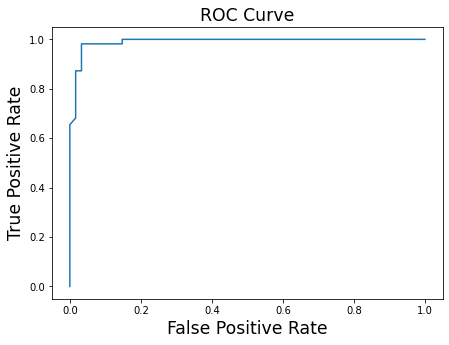

In [22]:
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate", size='xx-large')
plt.ylabel("True Positive Rate", size='xx-large')
plt.title("ROC Curve", size='xx-large');

In [23]:
print(classification_report(test['target'], test['pred'], target_names=['benign', 'malignant']))

              precision    recall  f1-score   support

      benign       0.97      0.95      0.96        61
   malignant       0.97      0.98      0.98       110

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



accuracy, precision, recall, f1

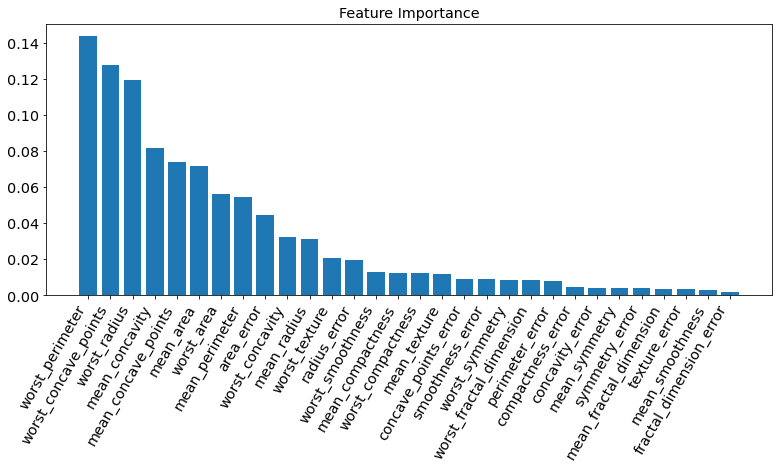

In [125]:
feat_imp = pd.DataFrame(zip(test.columns, model.feature_importances_)).sort_values(1, ascending = False)
plt.figure(figsize = (13, 5))
plt.bar(feat_imp[0], feat_imp[1])
plt.xticks(rotation = 60, ha = 'right', size = 'x-large')
plt.yticks(size = 'x-large')
plt.title('Feature Importance', size = 'x-large')
plt.savefig('./visualizations/feature_importance.jpg', bbox_inches = 'tight');

In [25]:
#model.predict_proba(test.drop(['target', 'pred'], axis = 1))[:, 0]
shap.initjs()
explainer = shap.KernelExplainer(model.predict_proba, train.drop('target', axis = 1))
shap_values = explainer.shap_values(test.drop(['target', 'pred'], axis = 1).iloc[126, :])
shap.force_plot(explainer.expected_value[0], shap_values[:, 0], test.drop(['target', 'pred'], axis = 1).iloc[126, :])

Using 318 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


## No model is perfect. By understanding the nature of the errors we can better identify ways to improve the model or areas where the model doesn't perform that well.

1. Are there features, or ranges of values in a feature, that are bad predictors
2. Are there trees that are bad predictors

#### We can start by seeing where the model made incorrect classifications

In [26]:
test[test['target']!=test['pred']]

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target,pred
126,0.313739,0.506595,0.303849,0.182015,0.360657,0.181707,0.123828,0.153330,0.354040,0.238837,...,0.312715,0.163070,0.501420,0.253330,0.303195,0.456701,0.375517,0.157156,0.0,1.0
157,0.466610,0.329726,0.446479,0.312492,0.196985,0.162107,0.120665,0.137724,0.395960,0.057287,...,0.348075,0.208120,0.109423,0.139428,0.150319,0.289897,0.189631,0.030697,1.0,0.0
363,0.450518,0.290159,0.434040,0.294634,0.399296,0.200294,0.137348,0.240308,0.219697,0.125737,...,0.332636,0.202468,0.413590,0.136421,0.132827,0.313505,0.163414,0.063295,1.0,0.0
297,0.226182,0.285086,0.215673,0.121994,0.424754,0.121956,0.062910,0.174702,0.282323,0.271904,...,0.172768,0.090543,0.280856,0.050887,0.048882,0.246048,0.081411,0.092549,0.0,1.0
73,0.322732,0.205614,0.322300,0.186893,0.433962,0.333170,0.182498,0.251938,0.304040,0.330666,...,0.298272,0.154149,0.461798,0.317170,0.221965,0.475258,0.201853,0.314574,0.0,1.0


#### We can further categorize the predictions as:
 - True Positive (TP): The model correctly predicted malignant
 - True Negative (TN): The model correctly predicted benign
 - False Positive (FP): The model incorrectly predicted malignant
 - False Negative (FN): The model incorrectly predicted benign

In [27]:
test['TP'] = ((test['target']==0)&(test['pred']==0)).astype(int)
test['TN'] = ((test['target']==1)&(test['pred']==1)).astype(int)
test['FP'] = ((test['target']==1)&(test['pred']==0)).astype(int)
test['FN'] = ((test['target']==0)&(test['pred']==1)).astype(int)

In [28]:
test[test['target']!=test['pred']]

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target,pred,TP,TN,FP,FN
126,0.313739,0.506595,0.303849,0.182015,0.360657,0.181707,0.123828,0.153330,0.354040,0.238837,...,0.303195,0.456701,0.375517,0.157156,0.0,1.0,0,0,0,1
157,0.466610,0.329726,0.446479,0.312492,0.196985,0.162107,0.120665,0.137724,0.395960,0.057287,...,0.150319,0.289897,0.189631,0.030697,1.0,0.0,0,0,1,0
363,0.450518,0.290159,0.434040,0.294634,0.399296,0.200294,0.137348,0.240308,0.219697,0.125737,...,0.132827,0.313505,0.163414,0.063295,1.0,0.0,0,0,1,0
297,0.226182,0.285086,0.215673,0.121994,0.424754,0.121956,0.062910,0.174702,0.282323,0.271904,...,0.048882,0.246048,0.081411,0.092549,0.0,1.0,0,0,0,1
73,0.322732,0.205614,0.322300,0.186893,0.433962,0.333170,0.182498,0.251938,0.304040,0.330666,...,0.221965,0.475258,0.201853,0.314574,0.0,1.0,0,0,0,1


#### In this case a  FN would be the worst case scenario, where the existance of a malignant tumor was not caught. So we will look more closely at those scenarios.

# Visualizing the Random Forest

Recall that a random forest is comprised of multiple trees. Visualizing the tree can provide useful context to the decisions made in it. One way to visualize the tree is by using scikit learn's `export_graphviz` function, which will save off a static `.dot` file:

In [29]:
from sklearn.tree import export_graphviz
from subprocess import call

export_graphviz(model.estimators_[0], out_file='test_tree.dot', 
                feature_names = data['feature_names'],
                class_names = data['target_names'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

call(['dot', '-Tpng', 'test_tree.dot', '-o', 'test_tree.png', '-Gdpi=600'])

0

#### This is useful but has limited functionality and is hard to see how points traverse the tree. The model object itself provides all the pieces we need to visualize the tree in a notebook

# Understanding RandomForestClassifier model object

Each tree, or estimator, in the random forest can be accessed using `.estimator_`

In [30]:
# number of estimators
len(model.estimators_)

100

To access a single tree object, use `.tree_` on a single item from `.estimators_` 

In [31]:
# access a single tree, the first one in this case
model.estimators_[0].tree_

The total number of nodes in a tree is stored in the `.note_count` attribute

In [32]:
# total number of nodes in tree
model.estimators_[0].tree_.node_count

29

The `.features` attribute shows what feature is considered at each node. The numbers correspond to the column index position from the original dataframe. `-2` indicates a terminal node (no feature considered)

In [33]:
# feature considered at each node, based on column position of original df
# (-2 means a terminal node, no feature considered)
model.estimators_[0].tree_.feature

array([25,  2, 27, -2, 17, -2, -2, 22, -2, -2,  7, 25,  9, -2, 15, -2, -2,
       13, -2, -2, 23, -2, 15, -2, 12, -2,  1, -2, -2], dtype=int64)

The the right branch of a given node is found using `.children_right`. The value references the index position in the `.feature` attribute

For example, in this tree, the right branch for the first node in the tree is node `23`, because that is the node at index position `20` of the `.feature` attribute

`-1` means there is no right branch, since the node is a terminal node

In [34]:
model.estimators_[0].tree_.children_right

array([10,  7,  4, -1,  6, -1, -1,  9, -1, -1, 20, 17, 14, -1, 16, -1, -1,
       19, -1, -1, 22, -1, 24, -1, 26, -1, 28, -1, -1], dtype=int64)

The same is true for `.children_left`

In [35]:
model.estimators_[0].tree_.children_left

array([ 1,  2,  3, -1,  5, -1, -1,  8, -1, -1, 11, 12, 13, -1, 15, -1, -1,
       18, -1, -1, 21, -1, 23, -1, 25, -1, 27, -1, -1], dtype=int64)

The threshold value for the considered feature is under the `.threshold` attribute

The left path is selected if the feature is `<=` the threshold, and the right if the feature is `>`

In [36]:
model.estimators_[0].tree_.threshold

array([ 0.20026001,  0.36555871,  0.42027491, -2.        ,  0.25033151,
       -2.        , -2.        ,  0.3251656 , -2.        , -2.        ,
        0.27872764,  0.39459208,  0.13953244, -2.        ,  0.08958452,
       -2.        , -2.        ,  0.0225776 , -2.        , -2.        ,
        0.06440474, -2.        ,  0.2480548 , -2.        ,  0.04853225,
       -2.        ,  0.14913764, -2.        , -2.        ])

The impurity at each node in tree from training is in the `.impurity` attribute

This model used the default impurity value, `gini`

In [37]:
# 
model.estimators_[0].tree_.impurity

array([0.47577232, 0.17419074, 0.06322355, 0.        , 0.27777778,
       0.        , 0.        , 0.26035503, 0.        , 0.        ,
       0.41135734, 0.2268431 , 0.0928019 , 0.        , 0.04875   ,
       0.        , 0.        , 0.32      , 0.        , 0.        ,
       0.07262371, 0.        , 0.03772189, 0.        , 0.0831758 ,
       0.        , 0.04345679, 0.        , 0.        ])

# Constructing a tree

## We can organize the pices stored within the model object to visualize a tree

#### First create a dictionary that gathers the information belonging to a given node

In [38]:
def construct_tree_dict(estimator):
    tree_dict = {}
    single_tree = estimator.tree_
    for ind, (feat, thresh, imp, left, right) in enumerate(zip(single_tree.feature, single_tree.threshold, single_tree.impurity, single_tree.children_left, single_tree.children_right)):
        if feat != -2:
            tree_dict[ind] = {'feature': data_df.columns[feat],
                              'threshold': thresh,
                              'impurity': imp,
                              'left_node': left,
                              'right_node':right}
        else:
            tree_dict[ind] = {'feature': 'terminal_leaf',
                              'threshold': np.nan,
                              'impurity': imp,
                              'left_node': np.nan,
                              'right_node':np.nan}
    return tree_dict

In [39]:
tree_dict = construct_tree_dict(model.estimators_[0])

In [40]:
tree_dict[0]

{'feature': 'worst_compactness',
 'threshold': 0.2002600133419037,
 'impurity': 0.4757723191329457,
 'left_node': 1,
 'right_node': 10}

#### With the `graphviz` package we can use the node information to visualize the tree

In [41]:
g = Digraph('', strict=True) # this arg is important for updating edges later on

for node_id, node_data in tree_dict.items():
    g.node(str(node_id))
    if node_data['feature'] != 'terminal_leaf':
        g.node(str(node_data['left_node']))
        g.node(str(node_data['right_node']))
        g.edge(str(node_id), str(node_data['left_node']))
        g.edge(str(node_id), str(node_data['right_node']))

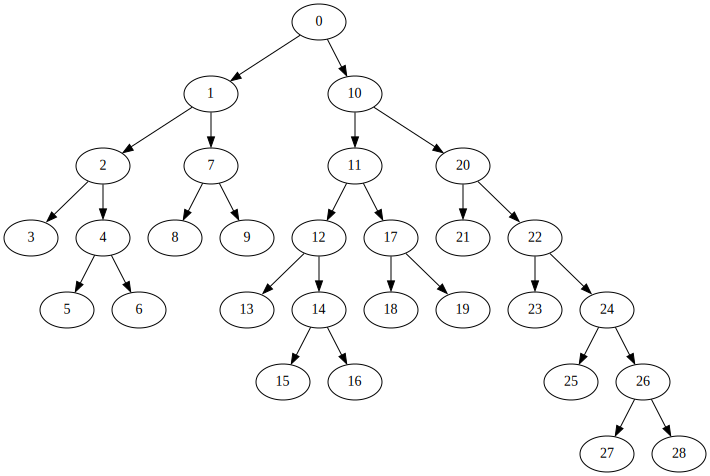

In [42]:
# the numbers inside each node refer to the index position in the model.estimators_[0].tree_.feature attribute
g.format = 'png'
g.render('tree', directory='visualizations').replace('\\', '/')
g

#### This output can be compared the `.dot` file made previously

# Visualizing the path through the tree

#### Now with the tree created we can add information about individual data points, such as the path a FN took through the tree to better understand why.

In [43]:
# Select a single FN
single_fn = test[test['FN']==1].head(1).reset_index(drop=True)
single_fn

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target,pred,TP,TN,FP,FN
0,0.313739,0.506595,0.303849,0.182015,0.360657,0.181707,0.123828,0.15333,0.35404,0.238837,...,0.303195,0.456701,0.375517,0.157156,0.0,1.0,0,0,0,1


#### We can now trace the FN's path through the tree

In [44]:
# make an empty list to store all the steps
fn_path = []

# start with the first node of the tree
node_id = 0 # always 0

# and add data to dict:
node_data = tree_dict[node_id]
node_data.update({'node_id': node_id, 'value': single_fn[node_data['feature']].values[0]})
fn_path.append(copy.deepcopy(node_data)) # to ensure values don't get overwritten

feat = fn_path[-1]['feature']

# traverse the tree until encounter a termainal leaf
while feat != 'terminal_leaf':
    # determine if should follow left or right path
    if fn_path[-1]['value'] <= fn_path[-1]['threshold']:
        fn_path[-1]['comparison'] = '<='# For making the graph later
        node_id = fn_path[-1]['left_node']
    elif fn_path[-1]['value'] > fn_path[-1]['threshold']:
        fn_path[-1]['comparison'] = '>'
        node_id = fn_path[-1]['right_node']
    else:
        print('something went wrong')
        break
    node_data = tree_dict[node_id]
    try:
        node_data.update({'node_id': node_id, 'value': single_fn[node_data['feature']].values[0]})
    except KeyError:
        node_data.update({'node_id': node_id, 'value': np.nan}) # when get to a terminal leaf
    fn_path.append(copy.deepcopy(node_data))
    feat = fn_path[-1]['feature']
    

#### With the path created, we can highlight it on the tree

In [45]:
for step in fn_path[:-1]:
    if step['comparison'] == '<=':
        g.edge(str(step['node_id']), str(step['left_node']), color = 'red')
    else:
        g.edge(str(step['node_id']), str(step['right_node']), color = 'red')

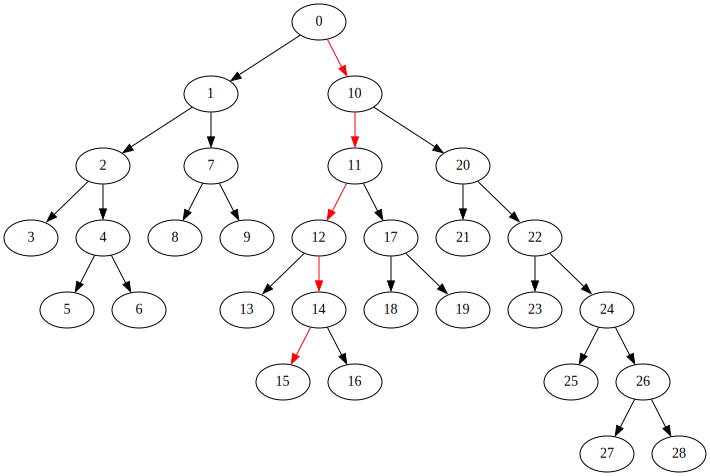

In [46]:
g.render('tree_fn', directory='visualizations').replace('\\', '/')
g

#### We can compare this with other TPs to see where this data point may have diverged from others

In [47]:
ten_tp = test[test['TP']==1].head(10).reset_index(drop=True)

In [48]:
ten_tp

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target,pred,TP,TN,FP,FN
0,0.401297,0.330402,0.400180,0.256797,0.510698,0.315686,0.343486,0.401938,0.439899,0.168492,...,0.302796,0.520275,0.250739,0.164961,0.0,0.0,1,0,0,0
1,0.276823,0.426784,0.286573,0.152577,0.507087,0.492362,0.397142,0.341004,0.536869,0.475569,...,0.501757,0.679381,0.363099,0.454283,0.0,0.0,1,0,0,0
2,0.624686,0.482246,0.690415,0.467232,0.685836,1.000000,0.879569,0.797217,0.932323,0.662595,...,0.613498,0.861856,0.763848,0.292536,0.0,0.0,1,0,0,0
3,0.419755,0.481569,0.414000,0.271135,0.283290,0.247899,0.232849,0.266600,0.397475,0.072030,...,0.185463,0.384536,0.245220,0.051358,0.0,0.0,1,0,0,0
4,0.459511,0.354751,0.437496,0.302906,0.201679,0.158702,0.085497,0.114662,0.396970,0.069292,...,0.197843,0.300241,0.613444,0.138987,0.0,0.0,1,0,0,0
5,0.416442,0.446398,0.427821,0.271092,0.567572,0.477946,0.499766,0.471123,0.523232,0.491786,...,0.587540,0.698969,0.336882,0.460186,0.0,0.0,1,0,0,0
6,0.636992,0.408184,0.622003,0.487593,0.350907,0.287467,0.229592,0.386928,0.281818,0.118155,...,0.215815,0.606529,0.205795,0.080742,0.0,0.0,1,0,0,0
7,0.593923,0.310788,0.592288,0.455355,0.563059,0.444206,0.514761,0.527833,0.369697,0.327717,...,0.488898,0.680412,0.276562,0.290240,0.0,0.0,1,0,0,0
8,0.359648,0.399729,0.370534,0.212641,0.476393,0.513527,0.333880,0.436531,0.602020,0.406066,...,0.442412,0.928179,0.532032,0.475272,0.0,0.0,1,0,0,0
9,0.496427,0.506256,0.499689,0.356776,0.471879,0.432243,0.505858,0.518390,0.241414,0.288332,...,0.390575,0.591409,0.117288,0.248983,0.0,0.0,1,0,0,0


In [49]:
def find_path(tree_dict, point_series):
    path = []
    node_id = 0
    
    node_data = tree_dict[node_id]
    node_data.update({'node_id': node_id, 'value': point_series[node_data['feature']]}) # Need to add node_id for visualization purposes
    
    feat = node_data['feature']

    while feat != 'terminal_leaf':
        if node_data['value'] <= node_data['threshold']:
            node_data['comparison'] = '<='
            path.append(copy.deepcopy(node_data))
            node_id = node_data['left_node']
        elif node_data['value'] > node_data['threshold']:
            node_data['comparison'] = '>'
            path.append(copy.deepcopy(node_data))
            node_id = node_data['right_node']
        else:
            print('something went wrong')
            break
        node_data = tree_dict[node_id]
        node_data['node_id'] = node_id
        try:
            node_data.update({'node_id': node_id, 'value': point_series[node_data['feature']]})
        except KeyError:
            node_data.update({'node_id': node_id, 'value': np.nan})
        feat = node_data['feature']
    path.append(copy.deepcopy(node_data))
    return path

In [50]:
tp_paths = [find_path(tree_dict, row) for ind, row in ten_tp.iterrows()]

In [51]:
# Increases thickness of line based on the number of points that take a certain step
def adjust_edge_width(edge_counter, top_node, bottom_node):
    try:
        edge_counter[(top_node, bottom_node)] += 1
    except KeyError:
        edge_counter[(top_node, bottom_node)] = 1
    return edge_counter

In [52]:
edge_counter = {}
for path in tp_paths:
    for step in path[:-1]:
        try:
            if step['comparison'] == '<=':
                edge_counter = adjust_edge_width(edge_counter, step['node_id'], step['left_node'])
                g.edge(str(step['node_id']), str(step['left_node']), color = 'blue', penwidth = str(min(5, edge_counter[(step['node_id'], step['left_node'])])))
            else:
                edge_counter = adjust_edge_width(edge_counter, step['node_id'], step['right_node'])
                g.edge(str(step['node_id']), str(step['right_node']), color = 'blue', penwidth = str(min(5, edge_counter[(step['node_id'], step['right_node'])])))
        except KeyError:
            continue

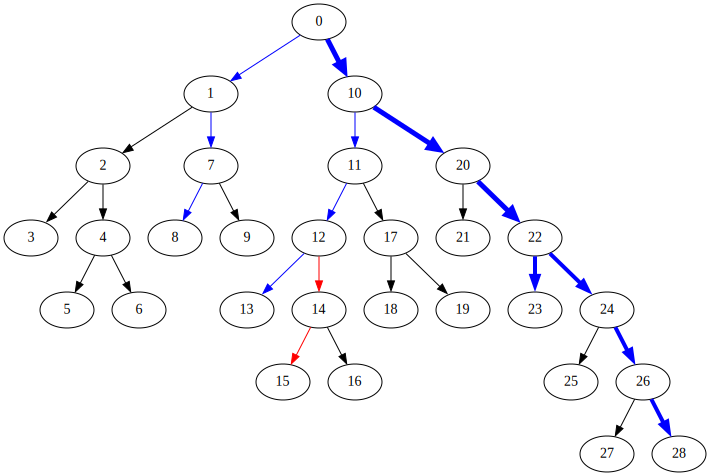

In [53]:
g.render('tree_fn_tps', directory='visualizations').replace('\\', '/')
g

#### In the above example the divergence point was node 12. We can see what feature and threshold was considered at that node by accessing the tree_dict

In [54]:
tree_dict[12]

{'feature': 'mean_fractal_dimension',
 'threshold': 0.1395324394106865,
 'impurity': 0.09280190362879237,
 'left_node': 13,
 'right_node': 14,
 'node_id': 12,
 'value': 0.06929233361415355,
 'comparison': '<='}

#### We can see that 'mean_fractal_dimension' was considered and the threshold was 0.1395324394106865. This feature/threshold _could_ warrant some further investigation but lets add the rest of the FNs and TPs and get a better picture

In [55]:
fn_paths = [find_path(tree_dict, row) for ind, row in test[test['FN']==1].reset_index(drop=True).iterrows()]

In [56]:
tp_paths = [find_path(tree_dict, row) for ind, row in test[test['TP']==1].reset_index(drop=True).iterrows()]

In [57]:
def add_paths(df, color, g):
    edge_counter = {}
    for path in df:
        for step in path[:-1]:
            try:
                if step['comparison'] == '<=':
                    edge_counter = adjust_edge_width(edge_counter, step['node_id'], step['left_node'])
                    g.edge(str(step['node_id']), str(step['left_node']), color = color, penwidth = str(min(5, edge_counter[(step['node_id'], step['left_node'])])))
                else:
                    edge_counter = adjust_edge_width(edge_counter, step['node_id'], step['right_node'])
                    g.edge(str(step['node_id']), str(step['right_node']), color = color, penwidth = str(min(5, edge_counter[(step['node_id'], step['right_node'])])))
            except KeyError:
                continue
    return g

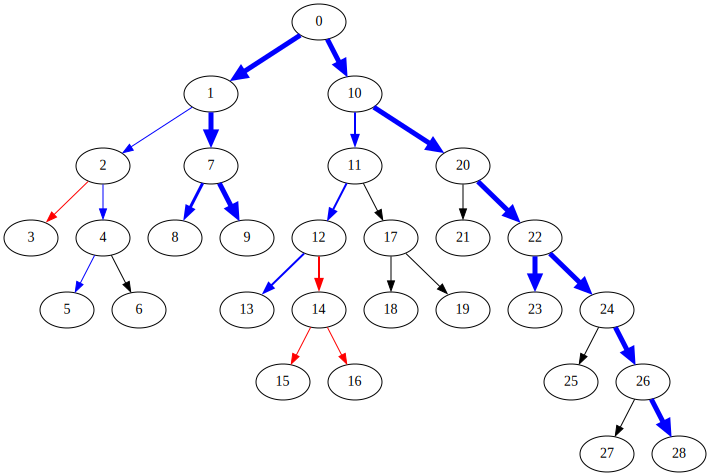

In [58]:
g = add_paths(fn_paths, 'red', g)
g = add_paths(tp_paths, 'blue', g)
g.render('tree_all_fn_tps', directory='visualizations').replace('\\', '/')
g

#### We see 12 is a divergence point for 2 FNs and 2 is a divergence point for the other. Can we safely say that these 2 features lead to the FNs?

#### Remember that a random forest includes multiple trees (100 in this case). The final prediction is based on all the trees. For this specific tree it incorrectly predicted the FNs, but others may predict some or all of the points correctly or diverge at different features.

#### To better capture the comprehensive picture of model performance, we would have to expand to all trees. Furthermore, we need to compare where FNs diverge from TPs and compare that to where TPs diverge from each other. Let's start with seeing where FNs tend to diverge from TPs and what the feature values tend to be.

# Find divergence points

In [59]:
# Make pairwise combinations of each FN and TP
combos = [[f, t] for f in fn_paths for t in tp_paths]

In [60]:
# Do the same for each TP for comparison
combos_tp = [[t_1, t_2] for t_1 in tp_paths for t_2 in tp_paths]

In [61]:
def find_divergence_features(combos):
    divergence_feats = []
    for ind, c in enumerate(combos):
        c = list(zip(*c)) # switch the orientation of the combinations to compare each step through the tree
        for ind, (f, t) in enumerate(c):
            if f['feature'] != t['feature']: # find where the steps are different
                divergence_feats.append(c[ind-1][0]['feature']) # add the previous step as the divergence point
    return divergence_feats

## Now we can compare the divergence points between FNs and TPs as well as between TPs

In [62]:
divergence_feats_fn = find_divergence_features(combos)
#sorted(Counter(divergence_feats_fn).items(), key=lambda x: x[1], reverse=True) # count the different divergence feats

In [63]:
divergence_feats_tp = find_divergence_features(combos_tp)
#sorted(Counter(divergence_feats_tp).items(), key=lambda x: x[1], reverse=True)

In [64]:
pd.DataFrame([Counter(divergence_feats_tp), Counter(divergence_feats_fn)]).T.rename(columns = {0: 'tp', 1: 'fn'}).sort_values('fn', ascending = False)

,tp,fn
worst_compactness,1552.0,188.0
mean_concave_points,872.0,112.0
mean_fractal_dimension,28.0,82.0
mean_perimeter,754.0,57.0
worst_concave_points,57.0,41.0
compactness_error,714.0,28.0
worst_area,760.0,NaN
worst_perimeter,697.0,NaN
concave_points_error,14.0,NaN


#### Based on the number of times a feature was considered at divergence points, `mean_fractal_dimension` was considered relatively frequently when separating fns from tps, meaning it may be a noteably important feature. Conversely, `compactness_error` wasn't considered that often when fns diverged from tps, but somewhat often when separating tps from each other, meaning it may not be a very useful feature. These differences don't look at the values of the features considered at the divergence points. Let's dig deeper to see if we can gain more understanding about what could differentiate FNs from TPs

In [65]:
def calc_divergence_difference(combos):
    divergence_feat_dif = {}
    for ind, c in enumerate(combos):
        c = list(zip(*c))
        for ind, (f, t) in enumerate(c):
            if f['feature'] != t['feature']:
                # Calculate the difference in value at the divergence point
                try:
                    divergence_feat_dif[c[ind-1][0]['feature']].append(c[ind-1][0]['value'] - c[ind-1][1]['value'])
                except:
                    divergence_feat_dif[c[ind-1][0]['feature']] = [c[ind-1][0]['value'] - c[ind-1][1]['value']]
    return divergence_feat_dif

In [66]:
divergence_feat_fn_diff = calc_divergence_difference(combos)
for k, v in divergence_feat_fn_diff.items():
    divergence_feat_fn_diff[k] = np.mean(v) # since a feature can be considered multiple times in a tree, calculate average difference

In [67]:
divergence_feat_tp_diff = calc_divergence_difference(combos_tp)
for k, v in divergence_feat_tp_diff.items():
    divergence_feat_tp_diff[k] = np.mean(v)

Put the data in a dataframe to make it easier to compare divergence differences

In [68]:
tp_div_df = pd.DataFrame(divergence_feat_tp_diff, index = ["tp_v_tp"]).T
fn_div_df = pd.DataFrame(divergence_feat_fn_diff, index = ["fn_v_tp"]).T
compare_tp_div_df = pd.merge(fn_div_df, tp_div_df, how = 'left', left_index = True, right_index = True)
compare_tp_div_df['diff'] = abs(compare_tp_div_df['fn_v_tp'] - compare_tp_div_df['tp_v_tp'])
compare_tp_div_df.sort_values('diff', ascending = False)

,fn_v_tp,tp_v_tp,diff
mean_fractal_dimension,0.043236,-0.296134,0.339370
mean_perimeter,-0.291462,0.026217,0.317678
mean_concave_points,-0.313190,-0.022669,0.290521
worst_concave_points,-0.112729,0.169103,0.281833
compactness_error,-0.173474,0.015122,0.188596
worst_compactness,-0.107227,-0.007436,0.099790


#### We can see that `mean_fractal_dimension` does have a big difference, along with `mean_perimeter`.

#### We should also consider the divergence points of TPs from TNs, so that we don't identify features that are unimportant for distinguishing TPs from TNs. Let's repeat the above process and include divergence points of TNs from TPs

In [69]:
# Get all TNs
tn_paths = [find_path(tree_dict, row) for ind, row in test[test['TN']==1].reset_index(drop=True).iterrows()]

# Make pairwise combinations of each TN and TP
combos_tn = [[n, p] for n in tn_paths for p in tp_paths]

# Differences in feature value at divergence points between TNs and TPs
divergence_feat_tn_diff = calc_divergence_difference(combos_tn)
for k, v in divergence_feat_tn_diff.items():
    divergence_feat_tn_diff[k] = np.mean(v)
    
tn_div_df = pd.DataFrame(divergence_feat_tn_diff, index = ["tn_v_tp"]).T

compare_tp_tn_div_df = pd.merge(compare_tp_div_df, tn_div_df, how = 'left', left_index = True, right_index = True)
#compare_tp_tn_div_df.to_csv('compare_tp_tn_div_df.csv')
compare_tp_tn_div_df

,fn_v_tp,tp_v_tp,diff,tn_v_tp
mean_concave_points,-0.313190,-0.022669,0.290521,-0.337271
worst_compactness,-0.107227,-0.007436,0.099790,-0.191792
mean_fractal_dimension,0.043236,-0.296134,0.339370,0.076210
compactness_error,-0.173474,0.015122,0.188596,-0.021734
mean_perimeter,-0.291462,0.026217,0.317678,-0.282584
worst_concave_points,-0.112729,0.169103,0.281833,-0.157054


#### The average difference for `mean_concave_points` between FNs and TPs is similar to TNs vs TPs, which could contribute to incorrect predictions by the model. The same is true for `mean_fractal_dimension` and `mean_perimeter`. The difference for FNs vs TPs for `worst_compactness` is in between that of TPs vs TPs and TNs vs TPs, indicating it also possibly contributes to incorrect predictions, but less clearly. The difference for FNs vs TPs for `compactness_error` is much greater than the differences for TPs vs TPs and TNs vs TPs, indicating it is unlikely to contribute to incorrect predictions. The same is true for `worst_concave_points`, though in the other direction.

#### As mentioned previously, this is only one tree, lets expand out to all trees and see if there is a larger trend we can observe

# Find divergence points for all trees

In [70]:
def calc_divergence_value_difference(combos):
    divergence_feat_dif = {}
    for c in combos:
        c = list(zip(*c))
        for ind, (f, t) in enumerate(c):
            if f['feature'] != t['feature']:
                # Calculate the difference in value at the divergence point
                try:
                    divergence_feat_dif[c[ind-1][0]['feature']+'_diff'].append(c[ind-1][0]['value'] - c[ind-1][1]['value'])
                    divergence_feat_dif[c[ind-1][0]['feature']+'_val'].append(c[ind-1][0]['value'])
                except:
                    divergence_feat_dif[c[ind-1][0]['feature']+'_diff'] = [c[ind-1][0]['value'] - c[ind-1][1]['value']]
                    divergence_feat_dif[c[ind-1][0]['feature']+'_val'] = [c[ind-1][0]['value']]
    return divergence_feat_dif

def find_all_tree_divergence_points(model, test_df):
    
    fns = test_df[test_df['FN']==1].reset_index(drop=True)
    tps = test_df[test_df['TP']==1].reset_index(drop=True)
    tns = test_df[test_df['TN']==1].reset_index(drop=True)
    
    divergence_feats_fn = {}
    divergence_feats_tp = {}
    divergence_feats_tn = {}
    
    all_divergence_feat_fn_diff = {}
    all_divergence_feat_tp_diff = {}
    all_divergence_feat_tn_diff = {}
    
    for estimator in model.estimators_:
        tree_dict = construct_tree_dict(estimator)
        
        fn_paths = [find_path(tree_dict, row) for ind, row in fns.iterrows()]
        tp_paths = [find_path(tree_dict, row) for ind, row in tps.iterrows()]
        tn_paths = [find_path(tree_dict, row) for ind, row in tns.iterrows()]
        
        # Make pairwise combinations of each FN and TP
        combos_fn = [[f, t] for f in fn_paths for t in tp_paths]
        
        # Do the same for each TP and TN for comparison
        combos_tp = [[t_1, t_2] for t_1 in tp_paths for t_2 in tp_paths]
        combos_tn = [[n, p] for n in tn_paths for p in tp_paths]
        
        tree_diverge_fn = find_divergence_features(combos_fn)
        tree_diverge_tp = find_divergence_features(combos_tp)
        tree_diverge_tn = find_divergence_features(combos_tn)
        
        for k, v in Counter(tree_diverge_fn).items():
            try:
                divergence_feats_fn[k] += v
            except KeyError:
                divergence_feats_fn[k] = v
        for k, v in Counter(tree_diverge_tp).items():
            try:
                divergence_feats_tp[k] += v
            except KeyError:
                divergence_feats_tp[k] = v
        for k, v in Counter(tree_diverge_tn).items():
            try:
                divergence_feats_tn[k] += v
            except KeyError:
                divergence_feats_tn[k] = v
        
        divergence_feat_fn_diff = calc_divergence_value_difference(combos_fn)
        for k, v in divergence_feat_fn_diff.items():
            try:
                all_divergence_feat_fn_diff[k].extend(v)
            except KeyError:
                all_divergence_feat_fn_diff[k] = v
        
        divergence_feat_tp_diff = calc_divergence_value_difference(combos_tp)
        for k, v in divergence_feat_tp_diff.items():
            try:
                all_divergence_feat_tp_diff[k].extend(v)
            except KeyError:
                all_divergence_feat_tp_diff[k] = v
            
        divergence_feat_tn_diff = calc_divergence_value_difference(combos_tn)
        for k, v in divergence_feat_tn_diff.items():
            try:
                all_divergence_feat_tn_diff[k].extend(v)
            except KeyError:
                all_divergence_feat_tn_diff[k] = v

    all_divergence_feat_fn_diff = {k: np.mean(v) for k, v in all_divergence_feat_fn_diff.items()}
    all_divergence_feat_tp_diff = {k: np.mean(v) for k, v in all_divergence_feat_tp_diff.items()}
    all_divergence_feat_tn_diff = {k: np.mean(v) for k, v in all_divergence_feat_tn_diff.items()}
    
    tp_div_df = pd.DataFrame(all_divergence_feat_tp_diff, index = ["tp"]).T
#     print(tp_div_df.index)
    fn_div_df = pd.DataFrame(all_divergence_feat_fn_diff, index = ["fn"]).T
#     print(fn_div_df.index)
    compare_tp_div_df = pd.merge(fn_div_df, tp_div_df, how = 'left', left_index = True, right_index = True)
    tn_div_df = pd.DataFrame(all_divergence_feat_tn_diff, index = ["tn"]).T
    compare_tp_tn_div_df = pd.merge(compare_tp_div_df, tn_div_df, how = 'left', left_index = True, right_index = True)
    return (dict(sorted(divergence_feats_fn.items(), key=lambda x: x[1], reverse=True)),
            dict(sorted(divergence_feats_tp.items(), key=lambda x: x[1], reverse=True)),
            dict(sorted(divergence_feats_tn.items(), key=lambda x: x[1], reverse=True)),
            divergence_feat_fn_diff, divergence_feat_tp_diff, divergence_feat_tn_diff, compare_tp_tn_div_df)

In [71]:
divergence_feats_fn, divergence_feats_tp, divergence_feats_tn, divergence_feat_fn_diff, divergence_feat_tp_diff, divergence_feat_tn_diff, compare_tp_tn_div_df = find_all_tree_divergence_points(model, test)


In [72]:
# Clean up the dataframe a little

compare_tp_tn_div_df = compare_tp_tn_div_df.reset_index()

compare_tp_tn_div_df.columns = ['feat', 'fn_v_tp', 'tp_v_tp', 'tn_v_tp']

compare_tp_tn_fn = pd.concat([compare_tp_tn_div_df['feat'].str.rpartition('_')[[0, 2]], compare_tp_tn_div_df[['fn_v_tp', 'tp_v_tp', 'tn_v_tp']]], axis = 1).pivot(index=0, columns=2)

compare_tp_tn_fn.to_csv('compare_tp_tn_fn.csv')

#compare_tp_tn_fn

In [73]:
compare_tp_tn_fn.columns = ['_'.join(c) for c in compare_tp_tn_fn.columns.values]

compare_tp_tn_fn_diffs = compare_tp_tn_fn.drop([c for c in compare_tp_tn_fn if '_val' in c], axis = 1)

compare_tp_tn_fn_diffs['fn_tn_spread'] = abs(compare_tp_tn_fn_diffs['fn_v_tp_diff'] - compare_tp_tn_fn_diffs['tn_v_tp_diff'])
compare_tp_tn_fn_diffs['fn_tp_spread'] = abs(compare_tp_tn_fn_diffs['fn_v_tp_diff'] - compare_tp_tn_fn_diffs['tp_v_tp_diff'])
compare_tp_tn_fn_diffs['spread_dif'] = compare_tp_tn_fn_diffs['fn_tp_spread'] - compare_tp_tn_fn_diffs['fn_tn_spread']

compare_tp_tn_fn_diffs = compare_tp_tn_fn_diffs.sort_values('spread_dif', ascending = False)

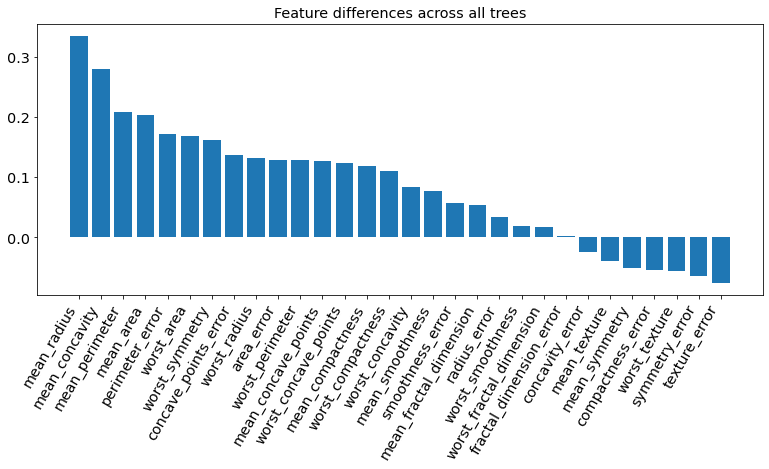

In [126]:
plt.figure(figsize = (13, 5))
plt.bar(compare_tp_tn_fn_diffs.index, compare_tp_tn_fn_diffs['spread_dif'])
plt.xticks(rotation = 60, ha = 'right', size = 'x-large')
plt.yticks(size = 'x-large')
plt.title('Feature differences across all trees', size = 'x-large')
plt.savefig('./visualizations/feature_difference.jpg', bbox_inches = 'tight');

### At this point there are a variety of things that can be done to further determine if and how these features led to incorrect predictions. One thing to note is that a divergence point doesn't exist in isolation, but rather after other decisions were made further up in the tree. Ideally, a divergence point would be considered in the context of previous decisions.

One extension is to look at values of features to see if there are ranges of values that could have led to the incorrect predictions. We'll first start by recombining the data and looking at the values of the 6 features of note.

In [75]:
test['split'] = 'test'
train['split'] = 'train'
recombined = pd.concat([train, test])

In [76]:
recombined

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_concave_points,worst_symmetry,worst_fractal_dimension,target,split,pred,TP,TN,FP,FN
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.912027,0.598462,0.418864,0.0,train,NaN,NaN,NaN,NaN,NaN
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.884880,1.000000,0.773711,0.0,train,NaN,NaN,NaN,NaN,NaN
5,0.258839,0.202570,0.267984,0.141506,0.678613,0.461996,0.369728,0.402038,0.518687,0.551179,...,0.598282,0.477035,0.454939,0.0,train,NaN,NaN,NaN,NaN,NaN
9,0.259312,0.484613,0.277659,0.140997,0.595558,0.675480,0.532568,0.424602,0.489899,0.683867,...,0.759450,0.552139,1.000000,0.0,train,NaN,NaN,NaN,NaN,NaN
10,0.427801,0.457558,0.407090,0.277540,0.265686,0.145114,0.077296,0.165159,0.236364,0.147641,...,0.342784,0.272620,0.193362,0.0,train,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,0.259785,0.300643,0.257757,0.143542,0.424483,0.265076,0.187559,0.189911,0.436869,0.290017,...,0.348797,0.285630,0.212908,1.0,test,1.0,0.0,1.0,0.0,0.0
476,0.341663,0.365911,0.335982,0.201442,0.331137,0.280412,0.118627,0.151988,0.225253,0.213353,...,0.460137,0.191011,0.154401,1.0,test,1.0,0.0,1.0,0.0,0.0
518,0.279190,0.287792,0.280976,0.148293,0.624447,0.450034,0.113051,0.263569,0.327778,0.475358,...,0.376632,0.200473,0.222288,1.0,test,1.0,0.0,1.0,0.0,0.0
252,0.603389,0.341901,0.600580,0.450689,0.483615,0.507699,0.566307,0.484095,0.339899,0.358256,...,0.861512,0.233392,0.489702,0.0,test,0.0,1.0,0.0,0.0,0.0


In [77]:
compare_tp_tn_fn.index

Index(['area_error', 'compactness_error', 'concave_points_error',
       'concavity_error', 'fractal_dimension_error', 'mean_area',
       'mean_compactness', 'mean_concave_points', 'mean_concavity',
       'mean_fractal_dimension', 'mean_perimeter', 'mean_radius',
       'mean_smoothness', 'mean_symmetry', 'mean_texture', 'perimeter_error',
       'radius_error', 'smoothness_error', 'symmetry_error', 'texture_error',
       'worst_area', 'worst_compactness', 'worst_concave_points',
       'worst_concavity', 'worst_fractal_dimension', 'worst_perimeter',
       'worst_radius', 'worst_smoothness', 'worst_symmetry', 'worst_texture'],
      dtype='object', name=0)

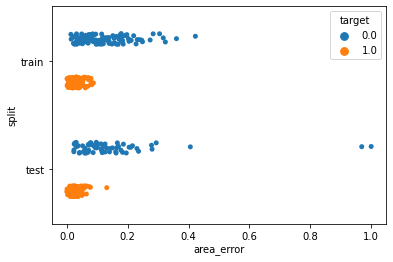

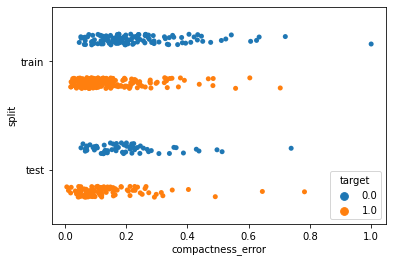

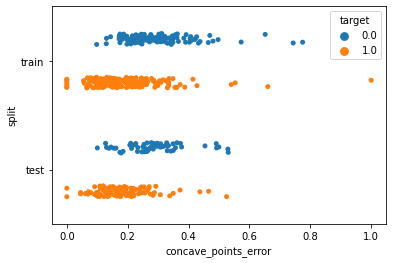

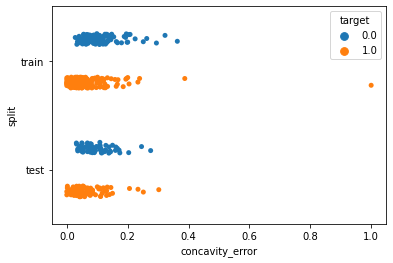

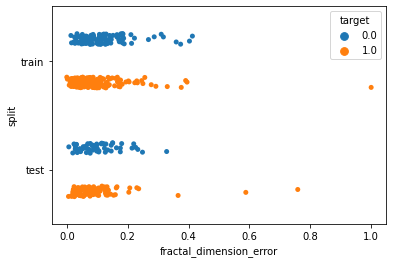

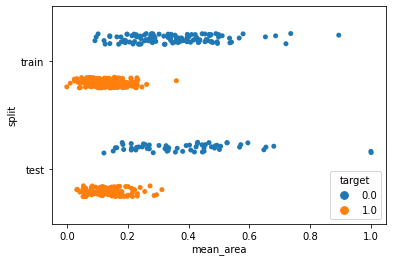

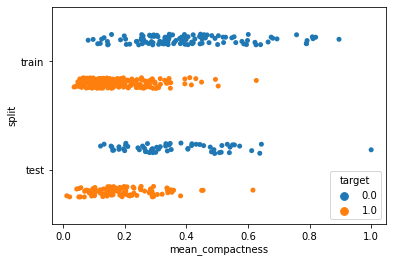

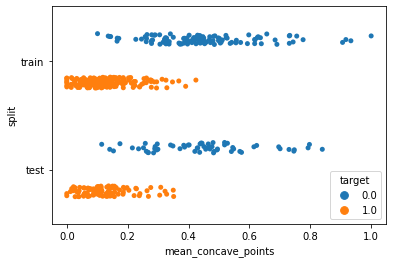

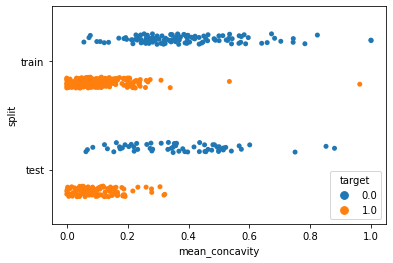

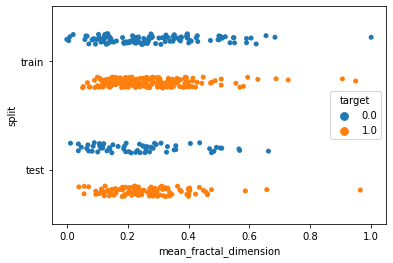

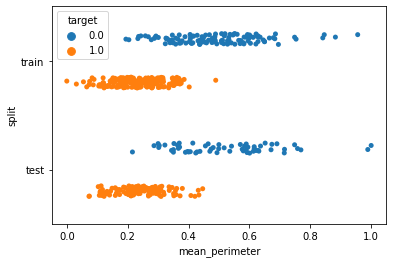

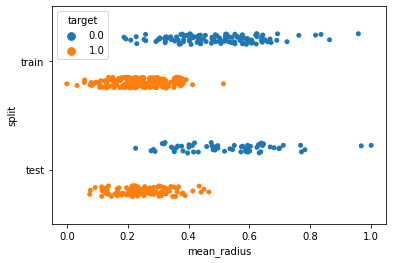

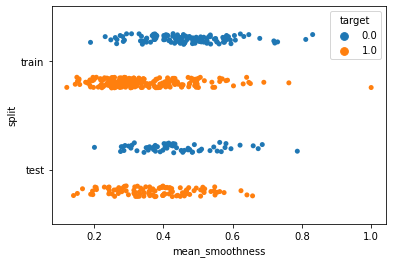

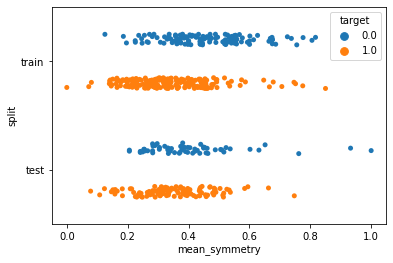

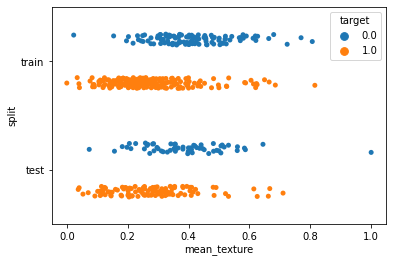

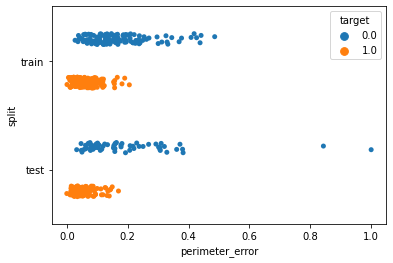

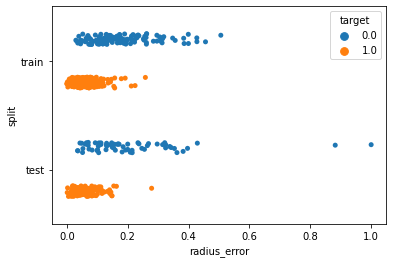

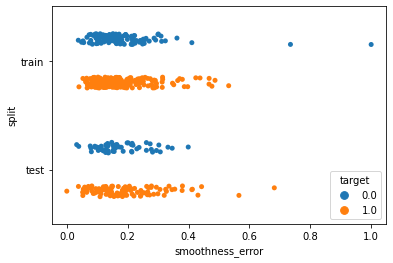

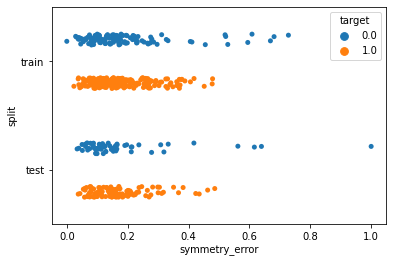

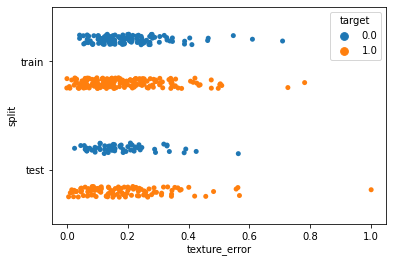

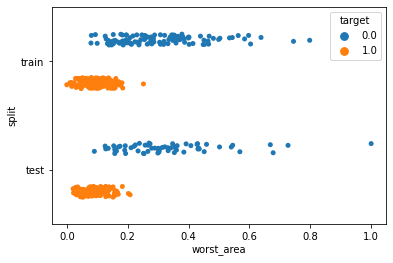

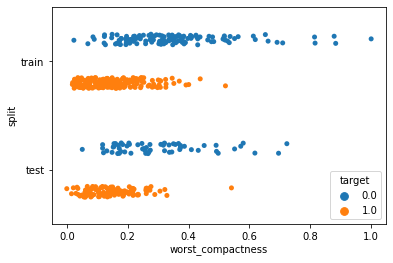

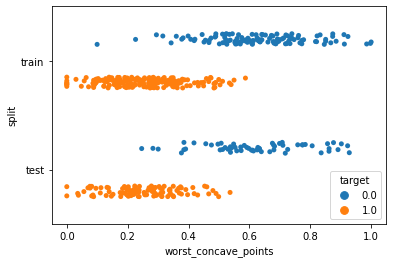

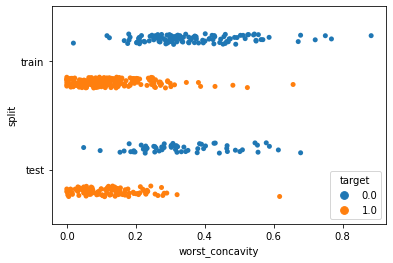

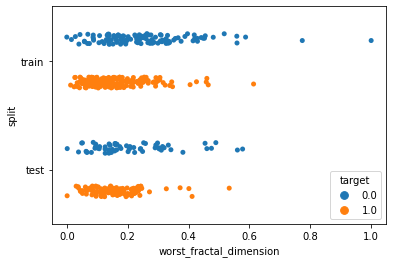

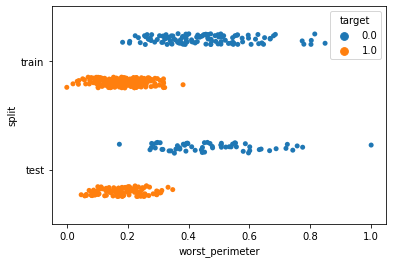

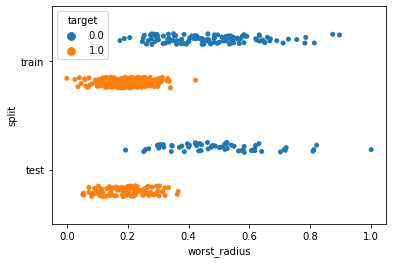

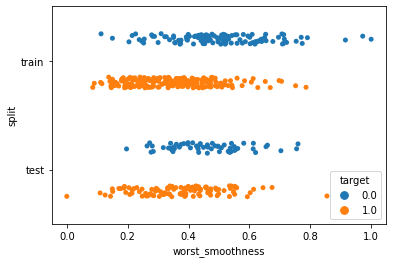

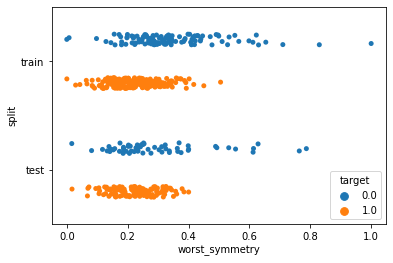

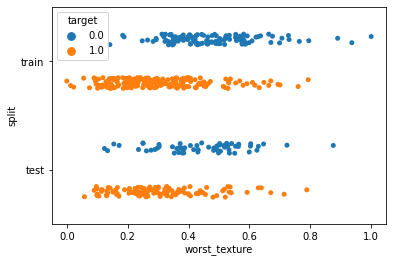

In [78]:
for c in compare_tp_tn_fn.index:
    sns.stripplot(x=recombined[c], y=recombined['split'], hue = recombined['target'], dodge = True)
    plt.show()

---

# Evaluating each tree's ability to predict

## In addition to looking at points and features, we can look at each individual tree and see how they are performing relative to the whole forest

## By looking at each tree's prediction individually we can understand the model in a different dimension

#### In addition to getting the classification from the model, we can also see the underlying probabilities feeding into the predictions

In [79]:
model.predict_proba(test.drop(['target', 'pred', 'TP', 'TN', 'FP', 'FN', 'split'], axis = 1))

array([[0.  , 1.  ],
       [0.04, 0.96],
       [0.03, 0.97],
       [0.  , 1.  ],
       [0.23, 0.77],
       [0.23, 0.77],
       [0.98, 0.02],
       [0.  , 1.  ],
       [0.84, 0.16],
       [0.07, 0.93],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.15, 0.85],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.04, 0.96],
       [0.  , 1.  ],
       [0.7 , 0.3 ],
       [0.73, 0.27],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.26, 0.74],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.02, 0.98],
       [0.  , 1.  ],
       [0.02, 0.98],
       [0.01, 0.99],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.98, 0.02],
       [0.09, 0.91],
       [0.  , 1.  ],
       [0.03, 0.97],
       [0.44, 0.56],
       [0.01, 0.99],
       [1.  , 0.  ],
       [0.82, 0.18],
       [0.  , 1.  ],
       [0.01, 0.99],
       [0.95, 0.05],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.01, 0.99],
       [0.  , 1.  ],
       [0.86, 0.14],
       [0.04, 0.96],
       [0.05,

We get an array with 2 columns, the columns correspond to the probabilities for the different classes (usually total to 1). We can confirm what class the column belongs to from `classes_`

In [80]:
model.classes_

array([0., 1.])

In [81]:
proba_cols = ['prob_' + str(c) for c in model.classes_]
probs = pd.DataFrame(model.predict_proba(test.iloc[:,:30]), columns = proba_cols)
test_prob = pd.concat([test.reset_index(drop=True), probs], axis = 1)

In [82]:
test_prob[(test_prob['FN']==1)|(test_prob['FP']==1)]

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_fractal_dimension,target,pred,TP,TN,FP,FN,split,prob_0.0,prob_1.0
34,0.313739,0.506595,0.303849,0.182015,0.360657,0.181707,0.123828,0.153330,0.354040,0.238837,...,0.157156,0.0,1.0,0,0,0,1,test,0.44,0.56
53,0.466610,0.329726,0.446479,0.312492,0.196985,0.162107,0.120665,0.137724,0.395960,0.057287,...,0.030697,1.0,0.0,0,0,1,0,test,0.78,0.22
57,0.450518,0.290159,0.434040,0.294634,0.399296,0.200294,0.137348,0.240308,0.219697,0.125737,...,0.063295,1.0,0.0,0,0,1,0,test,0.80,0.20
92,0.226182,0.285086,0.215673,0.121994,0.424754,0.121956,0.062910,0.174702,0.282323,0.271904,...,0.092549,0.0,1.0,0,0,0,1,test,0.03,0.97
137,0.322732,0.205614,0.322300,0.186893,0.433962,0.333170,0.182498,0.251938,0.304040,0.330666,...,0.314574,0.0,1.0,0,0,0,1,test,0.11,0.89


#### The model was very confident on two of the FNs, but less so on the other. This may indicate disagreement between the trees for the row that was close.

#### We can look at the individual predictions for each tree by iterating over `model.estimators_` and performing `.predict()`

In [83]:
tree_preds_list = []
for est in model.estimators_:
    tree_preds_list.append(est.predict(np.array(test.iloc[:,:30], dtype=np.float32))) # taking only columns used to fit and converting to appropriate datatype

In [84]:
tree_preds_df = pd.DataFrame(tree_preds_list).T
cols = ['tree_' + str(i) for i in range(len(model.estimators_))]
tree_preds_df.columns = cols

In [85]:
# Get predictions for row 34, the row where the model wasn't very confident
tree_preds_df.loc[34,:].value_counts()

1.0    56
0.0    44
Name: 34, dtype: int64

As expected the trees are split, with slightly more than half predicting class `1`. This is what underlies the probability calculation, the mean of predictions from all trees. The prediction from a given tree comes from the terminal leaf a row ends up in. During training, the data are continually split until the population of a given node is pure (only 1 class). The model has learned that anything that ends in that node is of a particular class. Therefore, when predicting, a row is labeled with a class based on the terminal leaf it ends in. This is repeated for each tree in the forest, and the mean of all the predictions gives the probability of belonging to a particular class (0 in this case). Lastly, a threshold is drawn (0.5 by default), where points with a probability above the threshold are assigned one class (1), while the ones below the threshold are assigned the other (0).

#### We can add the individual tree predictions to the test set and see if any trees are particularly bad at predicting

In [86]:
test_trees = pd.concat([test_prob, tree_preds_df], axis = 1)

In [87]:
test_trees.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,tree_90,tree_91,tree_92,tree_93,tree_94,tree_95,tree_96,tree_97,tree_98,tree_99
0,0.223342,0.317890,0.211043,0.116734,0.320574,0.101681,0.037090,0.057058,0.442424,0.238416,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.277770,0.394319,0.268399,0.157370,0.206554,0.195632,0.143533,0.092793,0.262626,0.235468,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.247953,0.349341,0.246562,0.131326,0.514309,0.293908,0.191542,0.107654,0.537374,0.399747,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.146670,0.182618,0.138000,0.073807,0.361470,0.084565,0.003742,0.011948,0.324747,0.221567,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.127550,0.115996,0.140488,0.054719,0.657850,0.616588,0.278351,0.349801,0.503535,0.964406,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


#### Now we can see for each tree, how many predictions were incorrect

In [88]:
tree_pred_dict = {i:0 for i in range(100)}
for ind, row in test_trees.iterrows():
    for t in range(100):
        if row['target'] != row['tree_'+str(t)]:
            tree_pred_dict[t] += 1

In [89]:
pd.DataFrame(sorted(tree_pred_dict.items(), key = lambda x: x[1], reverse = True), columns = ['tree', 'number_incorrect_preds'])

,tree,number_incorrect_preds
0,50,21
1,62,21
2,78,21
3,25,20
4,4,18
...,...,...
95,34,8
96,68,8
97,47,6
98,94,6


#### Looks like trees 50, 62, and 78 made the most errors, while tree 95 made the fewest

#### If we look at a histogram of tree errors, we can see it is somewhat normal, which makes sense due to the `random` part of the random forest

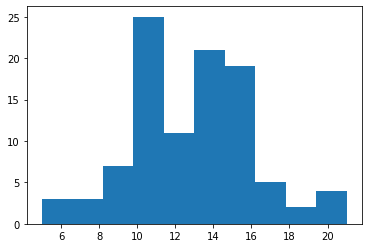

In [90]:
plt.hist(tree_pred_dict.values());

#### "Good" trees and "Bad" trees are subjective and at this point the cut off is arbitrary, perhaps we can enhance our criteria by factoring in if the incorrect prediction from a tree aided in an incorrect prediction from the model overall

In [91]:
tree_pred_dict_error = {i:0 for i in range(100)}
for ind, row in test_trees.iterrows():
    if row['target'] != row['pred']: # first check to see if overall model made an error
        for t in range(100):
            if row['target'] != row['tree_'+str(t)]: # then identify trees that contributed to the error
                tree_pred_dict_error[t] += 1

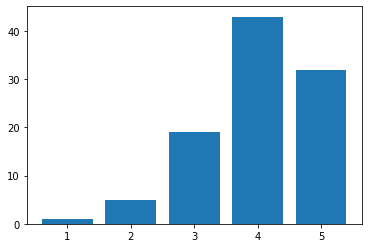

In [92]:
error_counts = Counter(tree_pred_dict_error.values())
plt.bar(error_counts.keys(), error_counts.values(), tick_label = [i for i in error_counts.keys()]);

#### There are only a total of 5 errors from the model (FP+FN), meaning there are some trees that always contribute to incorrect predictions. There are also no trees that were accurate in all of the errors, possibly indicating there may be some underlying data situation that the model has not fully captured. The distribution of model errors in the context of overall incorrect predictions is skewed left slightly, indicating that maybe instead of looking at "bad" trees, looking at "good" trees may be more informative

#### We can separate trees into "good" and "bad" trees and compare them

In [93]:
good_trees = []
bad_trees = []
mid_trees = []
for k, v in tree_pred_dict_error.items():
    if v <= 2:
        good_trees.append(k)
    elif v == 5:
        bad_trees.append(k)
    else:
        mid_trees.append(k)

The most accurate trees across all incorrect predictions:

In [94]:
good_trees

[2, 41, 68, 75, 76, 96]

The least accurate trees across all incorrect predictions:

In [95]:
bad_trees

[4,
 6,
 7,
 8,
 14,
 15,
 19,
 20,
 21,
 23,
 24,
 32,
 33,
 35,
 37,
 42,
 50,
 54,
 55,
 58,
 60,
 69,
 70,
 73,
 74,
 77,
 78,
 83,
 86,
 92,
 94,
 95]

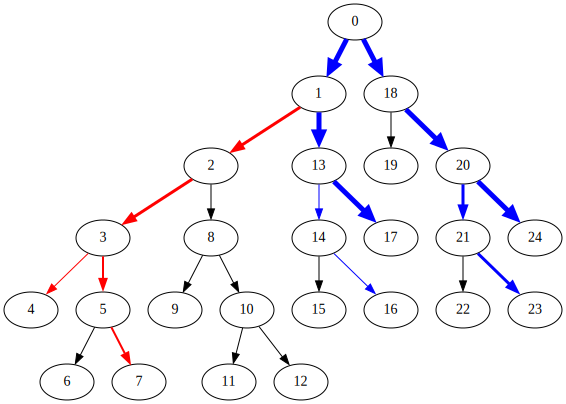

In [96]:
tree_95 = construct_tree_dict(model.estimators_[95])
g_95 = Digraph('', strict=True) # this arg is important for updating edges later on

for node_id, node_data in tree_95.items():
    g_95.node(str(node_id))
    if node_data['feature'] != 'terminal_leaf':
        g_95.node(str(node_data['left_node']))
        g_95.node(str(node_data['right_node']))
        g_95.edge(str(node_id), str(node_data['left_node']))
        g_95.edge(str(node_id), str(node_data['right_node']))

g_95 = add_paths([find_path(tree_95, row) for ind, row in test[test['FN']==1].reset_index(drop=True).iterrows()], 'red', g_95)
g_95 = add_paths([find_path(tree_95, row) for ind, row in test[test['FP']==1].reset_index(drop=True).iterrows()], 'orange', g_95)
g_95 = add_paths([find_path(tree_95, row) for ind, row in test[test['TP']==1].reset_index(drop=True).iterrows()], 'blue', g_95)

g_95.format = 'png'
g_95.render('bad_tree', directory='visualizations').replace('\\', '/')
g_95

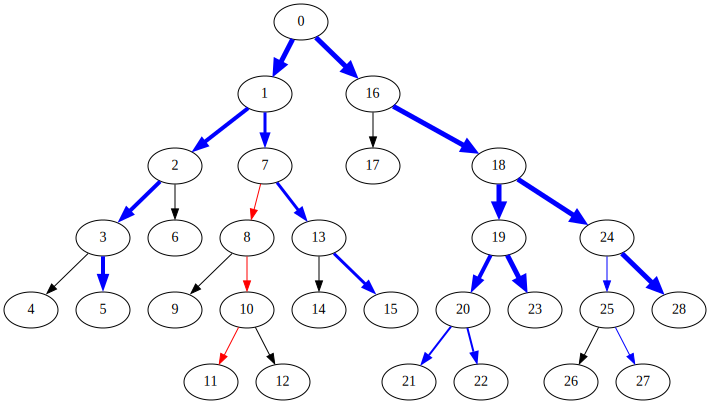

In [97]:
tree_2 = construct_tree_dict(model.estimators_[2])
g_2 = Digraph('', strict=True) # this arg is important for updating edges later on

for node_id, node_data in tree_2.items():
    g_2.node(str(node_id))
    if node_data['feature'] != 'terminal_leaf':
        g_2.node(str(node_data['left_node']))
        g_2.node(str(node_data['right_node']))
        g_2.edge(str(node_id), str(node_data['left_node']))
        g_2.edge(str(node_id), str(node_data['right_node']))

g_2 = add_paths([find_path(tree_2, row) for ind, row in test[test['FN']==1].reset_index(drop=True).iterrows()], 'red', g_2)
g_2 = add_paths([find_path(tree_2, row) for ind, row in test[test['FP']==1].reset_index(drop=True).iterrows()], 'orange', g_2)
g_2 = add_paths([find_path(tree_2, row) for ind, row in test[test['TP']==1].reset_index(drop=True).iterrows()], 'blue', g_2)

g_2.format = 'png'
g_2.render('good_tree', directory='visualizations').replace('\\', '/')
g_2

### A useful step now may be to characterize the "good" trees and "bad" trees to see if there are inherent differences in their construction

- number of branch points
- width/depth of trees
- which features are considered and how often

### Additionally, we can look at the path the incorrect predictions took through the trees to see if there are any notable differences between the "good" and "bad" trees

- what is the path the erroneous predictions take through the good vs the bad trees
- what is the threshold for each feature in good trees vs bad

In [98]:
num_branches_good = []
for t in good_trees:
    br_count = 0
    for v in construct_tree_dict(model.estimators_[t]).values():
        if v['feature'] != 'terminal_leaf':
            br_count += 1
    num_branches_good.append(br_count)
print(sum(num_branches_good)/len(num_branches_good))

11.833333333333334


In [99]:
num_branches_bad = []
for t in bad_trees:
    br_count = 0
    for v in construct_tree_dict(model.estimators_[t]).values():
        if v['feature'] != 'terminal_leaf':
            br_count += 1
    num_branches_bad.append(br_count)
print(sum(num_branches_bad)/len(num_branches_bad))

11.75


#### There don't seem to be any differences in the number of branches between good and bad trees

In [100]:
tree_2 = construct_tree_dict(model.estimators_[2])

In [101]:
def find_left_path(node, tree):
    path = [copy.deepcopy(node)]
    feat = tree[node]['feature']
    while feat != 'terminal_leaf':
        node = tree[node]['left_node']
        path.append(copy.deepcopy(node))
        feat = tree[node]['feature']
    return path

In [102]:
def backtrack(tree, path):
    position = -1
    try:
        while tree[path[position-1]]['right_node'] == path[position]:
            position -= 1
        return path[position-1]
    except IndexError:
        return None

In [103]:
def find_all_paths_in_tree(tree):
    paths = []
    path = find_left_path(0, tree)
    paths.append(path)
    backtrack_node = backtrack(tree, path)
    backtrack_path = find_left_path(tree[backtrack_node]['right_node'], tree)
    new_path = copy.deepcopy(paths[-1][:paths[-1].index(backtrack_node)+1]+backtrack_path)
    while new_path != paths[-1]:
        paths.append(new_path)
        backtrack_node = backtrack(tree, new_path)
        if backtrack_node is not None:
            backtrack_path = find_left_path(tree[backtrack_node]['right_node'], tree)
            new_path = copy.deepcopy(paths[-1][:paths[-1].index(backtrack_node)+1]+backtrack_path)
    return paths

In [104]:
def find_tree_width_depth(tree_paths):
    depth = max([len(l) for l in tree_paths])
    width = max(pd.DataFrame(tree_paths).nunique())
    return depth, width

In [105]:
depths = []
widths = []
for t in good_trees:
    tree = construct_tree_dict(model.estimators_[t])
    tree_paths = find_all_paths_in_tree(tree)
    depth, width = find_tree_width_depth(tree_paths)
    depths.append(depth)
    widths.append(width)
print(sum(depths)/len(depths))
print(sum(widths)/len(widths))

7.5
6.333333333333333


In [106]:
depths = []
widths = []
for t in bad_trees:
    tree = construct_tree_dict(model.estimators_[t])
    tree_paths = find_all_paths_in_tree(tree)
    depth, width = find_tree_width_depth(tree_paths)
    depths.append(depth)
    widths.append(width)
print(sum(depths)/len(depths))
print(sum(widths)/len(widths))

7.09375
6.25


#### The width and depth between good trees and bad trees also don't seem to be notable different

In [107]:
test_feat_dict = {}
for t in good_trees:
    for i in construct_tree_dict(model.estimators_[t]).values():
        if i['feature'] != 'terminal_leaf':
            try:
                test_feat_dict[i['feature']] += 1
            except KeyError:
                test_feat_dict[i['feature']] = 1
good_feat_dict_norm = {k: v/sum(test_feat_dict.values()) for k, v in test_feat_dict.items()}
dict(sorted(good_feat_dict_norm.items(), key = lambda item: item[1]))

{'mean_area': 0.014084507042253521,
 'mean_symmetry': 0.014084507042253521,
 'mean_radius': 0.014084507042253521,
 'mean_concavity': 0.014084507042253521,
 'worst_symmetry': 0.014084507042253521,
 'mean_texture': 0.028169014084507043,
 'perimeter_error': 0.028169014084507043,
 'worst_radius': 0.028169014084507043,
 'mean_compactness': 0.028169014084507043,
 'smoothness_error': 0.028169014084507043,
 'radius_error': 0.028169014084507043,
 'worst_texture': 0.028169014084507043,
 'mean_concave_points': 0.04225352112676056,
 'mean_fractal_dimension': 0.04225352112676056,
 'texture_error': 0.04225352112676056,
 'symmetry_error': 0.056338028169014086,
 'mean_perimeter': 0.056338028169014086,
 'worst_concavity': 0.056338028169014086,
 'concave_points_error': 0.056338028169014086,
 'worst_perimeter': 0.07042253521126761,
 'worst_smoothness': 0.07042253521126761,
 'worst_area': 0.07042253521126761,
 'worst_concave_points': 0.08450704225352113,
 'area_error': 0.08450704225352113}

In [108]:
test_bad_feat_dict = {}
for t in bad_trees:
    for i in construct_tree_dict(model.estimators_[t]).values():
        if i['feature'] != 'terminal_leaf':
            try:
                test_bad_feat_dict[i['feature']] += 1
            except KeyError:
                test_bad_feat_dict[i['feature']] = 1
bad_feat_dict_norm = {k: v/sum(test_bad_feat_dict.values()) for k, v in test_bad_feat_dict.items()}
dict(sorted(bad_feat_dict_norm.items(), key = lambda item: item[1]))

{'fractal_dimension_error': 0.007978723404255319,
 'symmetry_error': 0.010638297872340425,
 'concavity_error': 0.013297872340425532,
 'worst_fractal_dimension': 0.013297872340425532,
 'mean_radius': 0.018617021276595744,
 'mean_smoothness': 0.018617021276595744,
 'mean_symmetry': 0.018617021276595744,
 'mean_fractal_dimension': 0.02127659574468085,
 'compactness_error': 0.02127659574468085,
 'concave_points_error': 0.02127659574468085,
 'mean_perimeter': 0.023936170212765957,
 'radius_error': 0.023936170212765957,
 'worst_smoothness': 0.023936170212765957,
 'worst_symmetry': 0.026595744680851064,
 'worst_compactness': 0.02925531914893617,
 'texture_error': 0.02925531914893617,
 'perimeter_error': 0.034574468085106384,
 'mean_compactness': 0.03723404255319149,
 'mean_area': 0.03723404255319149,
 'mean_texture': 0.03723404255319149,
 'worst_concavity': 0.0425531914893617,
 'mean_concavity': 0.0425531914893617,
 'smoothness_error': 0.04521276595744681,
 'area_error': 0.04521276595744681,


The features considered most often in good trees:
- worst_concave_points
- area_error
- worst_perimeter
- worst_smoothness
- worst_area

The features considered least often in good trees:
- mean_area
- mean_symmetry
- mean_radius
- mean_concavity
- worst_symmetry

The features considered most often in bad trees:
- worst_perimeter

The features considered most least in bad trees:
- fractal_dimension_error
- symmetry_error
- concavity_error
- worst_fractal_dimension
- mean_radius
- mean_smoothness
- mean_symmetry

#### Aside from `worst_preimeter`, `mean_radius`, and `mean_symmetry` there is no overlap in the frequency of features considered in good vs bad trees. This difference could contribute to the trees producing incorrect predictions

In [109]:
set(bad_feat_dict_norm.keys()) - set(good_feat_dict_norm.keys())

{'compactness_error',
 'concavity_error',
 'fractal_dimension_error',
 'mean_smoothness',
 'worst_compactness',
 'worst_fractal_dimension'}

In [110]:
set(good_feat_dict_norm.keys()) - set(bad_feat_dict_norm.keys())

set()

#### Additionally, there are features that were considered in "bad" trees but not "good" trees

#### We can summarize the differences in proportions of feature consideration between "good" trees and "bad" trees in a scatterplot

In [111]:
wrong_preds = test_prob[(test_prob['FN']==1)|(test_prob['FP']==1)].drop(columns = ['target', 'pred', 'TP', 'FP', 'TN', 'FN', 'split'])
good_tree_wrong_pred_paths = []
for row, p in wrong_preds.iterrows():
    for t in good_trees:
        good_tree_wrong_pred_paths.append(find_path(construct_tree_dict(model.estimators_[t]), p))


In [112]:
good_feats_considered = {}
for p in good_tree_wrong_pred_paths:
    for s in p:
        if s['feature'] != 'terminal_leaf':
            try:
                good_feats_considered[s['feature']] += 1
            except KeyError:
                good_feats_considered[s['feature']] = 1

In [113]:
good_feats_considered_prop = {k: v/sum(good_feats_considered.values()) for k, v in good_feats_considered.items()}

In [114]:
bad_tree_wrong_pred_paths = []
for row, p in wrong_preds.iterrows():
    for t in bad_trees:
        bad_tree_wrong_pred_paths.append(find_path(construct_tree_dict(model.estimators_[t]), p))

bad_feats_considered = {}
for p in bad_tree_wrong_pred_paths:
    for s in p:
        if s['feature'] != 'terminal_leaf':
            try:
                bad_feats_considered[s['feature']] += 1
            except KeyError:
                bad_feats_considered[s['feature']] = 1
            
bad_feats_considered_prop = {k: v/sum(bad_feats_considered.values()) for k, v in bad_feats_considered.items()}

In [115]:
bad_df = pd.DataFrame(bad_feats_considered_prop.values(), index = bad_feats_considered_prop.keys())
good_df = pd.DataFrame(good_feats_considered_prop.values(), index = good_feats_considered_prop.keys())
good_bad_df = bad_df.merge(good_df, how = 'outer', left_index = True, right_index = True)
good_bad_df.columns = ['bad_prop', 'good_prop']
good_bad_df = good_bad_df.fillna(0)

In [116]:
good_bad_df.head()

,bad_prop,good_prop
area_error,0.044190,0.075
compactness_error,0.009820,0.000
concave_points_error,0.018003,0.025
concavity_error,0.004910,0.000
fractal_dimension_error,0.008183,0.000


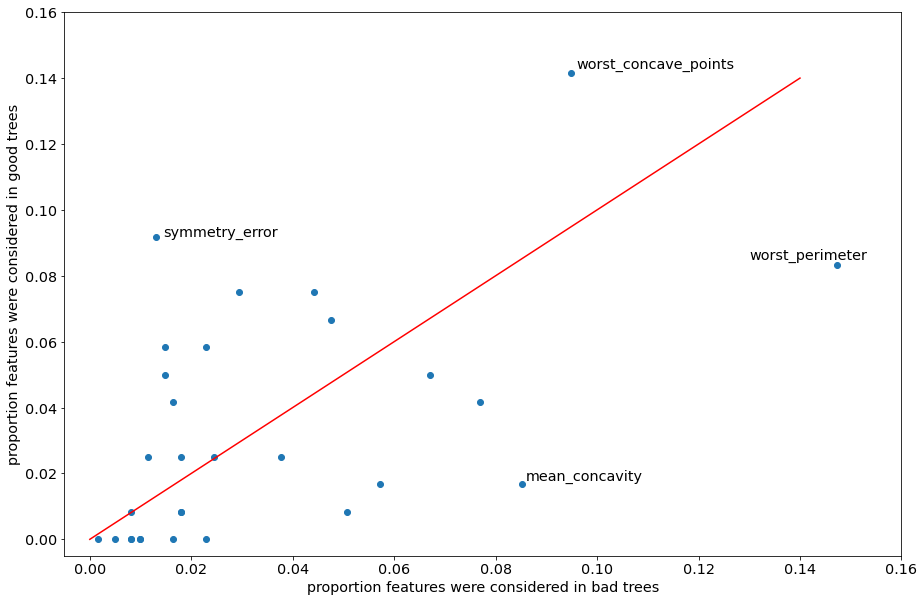

In [127]:
plt.figure(figsize = (15, 10))
plt.scatter(good_bad_df['bad_prop'], good_bad_df['good_prop'])
plt.xlim(-0.005, 0.16)
plt.ylim(-0.005, 0.16)
plt.plot([0, 0.02, 0.06, 0.14], [0, 0.02, 0.06, 0.14], color = 'red')
plt.xlabel('proportion features were considered in bad trees', size = 'x-large')
plt.ylabel('proportion features were considered in good trees', size = 'x-large')
plt.xticks(size = 'x-large')
plt.yticks(size = 'x-large')
pt_1 = good_bad_df[good_bad_df['good_prop'] > 0.14].index[0]
pt_2 = good_bad_df[good_bad_df['bad_prop'] > 0.14].index[0]
pt_3 = good_bad_df[(good_bad_df['bad_prop'] < 0.02)&(good_bad_df['good_prop'] > 0.08)].index[0]
pt_4 = good_bad_df[(good_bad_df['bad_prop'] > 0.08)&(good_bad_df['good_prop'] < 0.02)].index[0]
plt.annotate(pt_1, (0.096, 0.143), size = 'x-large')
plt.annotate(pt_2, (0.13, 0.085), size = 'x-large')
plt.annotate(pt_3, (0.0145, 0.092), size = 'x-large')
plt.annotate(pt_4, (0.086, 0.018), size = 'x-large')
plt.savefig('./visualizations/feature_consideration.jpg', bbox_inches = 'tight');

# So what?

These insights might be theoretically valuable, but practically what is the purpose? Performing a grid search, combination feature engineering, generating synthetic data (SMOTE), gathering more data are all methods that could mitigate any issues with the current model. The difference is that those methods use a brute force approach without first understanding why a model was not performing well in the first place. There is absolutely a place for those methodologies, but ideally it would be after gaining a deeper understanding of why the current model is not performing as expected. This would allow a more targeted approach when iterating on model training. If there are certain features that consistently are associated with incorrect predictions, that could indicate something is not being captured as expected. There could also be more targeted HPO. If used longitudinally, this could also be useful for detecting drift at a more precise level.

Additionally, this analysis provides more concrete explanations for why a model is performing at a certain level. I have found that providing visualizations and more tangible explanations are useful when discussing ML models with stakeholders who are not as well versed in Data Science practices. These artifacts could be used to advocate for improvements or changes to data processing pipelines or more heavily investing in additional technologies.

At the end of the day, understanding a model a such a granular level may not be necessary. This analysis was my attempt to answer the question "Why was this prediction wrong?" That question is not always a relevant one and there are many ways to answer the question. Since data science largely exists within a broader business context, developing tools for communicating with all members of an organization is useful. Additionally, there may be secondary benefits for developing these tools for use within a data science team.

The ability to scale these methods as they currently stand may be limited, for example with use in neural networks or reinforcement learning.

---

WIP

# Checking consecutive features

In theory, random forest models randomly select a feature to evaluate at each node in a tree. This means that overall, each feature should be considered a similar number of times. Additionally, consecutive feature pairs should also be evenly distributed. We can check these scenarios to verify tree construction is as expected.

In [118]:
Counter([v['feature'] for k, v in tree_dict.items()])

Counter({'worst_compactness': 2,
         'mean_perimeter': 1,
         'worst_concave_points': 1,
         'terminal_leaf': 15,
         'concave_points_error': 1,
         'worst_perimeter': 1,
         'mean_concave_points': 1,
         'mean_fractal_dimension': 1,
         'compactness_error': 2,
         'area_error': 1,
         'worst_area': 1,
         'perimeter_error': 1,
         'mean_texture': 1})

In [119]:
preceeding_feat = {i['feature']:[] for i in tree_dict.values()}
succeeding_feat = {i['feature']:[] for i in tree_dict.values()}
for k, v in tree_dict.items():
    if k != 0:
        pre_feat = [v_2['feature'] for k_2, v_2 in tree_dict.items() if v_2['left_node'] == k or v_2['right_node'] == k][0]
        preceeding_feat[v['feature']].append(pre_feat)
    if v['feature'] != 'terminal_leaf':
        succeeding_feat[v['feature']].append(tree_dict[v['left_node']]['feature'])
        succeeding_feat[v['feature']].append(tree_dict[v['right_node']]['feature'])

preceeding_feat = {k:Counter(v) for k, v in preceeding_feat.items()}
succeeding_feat = {k:Counter(v) for k, v in succeeding_feat.items()}

In [120]:
preceeding_feat

{'worst_compactness': Counter({'mean_concave_points': 1}),
 'mean_perimeter': Counter({'worst_compactness': 1}),
 'worst_concave_points': Counter({'mean_perimeter': 1}),
 'terminal_leaf': Counter({'worst_concave_points': 1,
          'concave_points_error': 2,
          'worst_perimeter': 2,
          'mean_fractal_dimension': 1,
          'compactness_error': 3,
          'area_error': 2,
          'worst_area': 1,
          'perimeter_error': 1,
          'mean_texture': 2}),
 'concave_points_error': Counter({'worst_concave_points': 1}),
 'worst_perimeter': Counter({'mean_perimeter': 1}),
 'mean_concave_points': Counter({'worst_compactness': 1}),
 'mean_fractal_dimension': Counter({'worst_compactness': 1}),
 'compactness_error': Counter({'mean_fractal_dimension': 1, 'worst_area': 1}),
 'area_error': Counter({'worst_compactness': 1}),
 'worst_area': Counter({'mean_concave_points': 1}),
 'perimeter_error': Counter({'compactness_error': 1}),
 'mean_texture': Counter({'perimeter_error': 